# Create RoBERTa Model with Classification Layer

In [1]:
!pip install tensorflow-datasets --quiet
!pip install tensorflow-text --quiet
!pip install pydot --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install pyarrow -quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.5 MB/s eta 0:00:00

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import random
import re

nltk.download('gutenberg')
from nltk.corpus import gutenberg

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from google.colab import drive

import pyarrow as pya
import pyarrow.parquet as pq

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Mount drive to retrieve data frame
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.__version__)

2.14.0


In [4]:
from transformers import TFRobertaModel , TFRobertaForSequenceClassification, RobertaTokenizer

checkpoint = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [5]:
MAX_SEQUENCE_LENGTH = 128

In [6]:
# Create RoBERTa with CNN
# multi-modal or multi-channel approach, where the RoBERTa model processes the input text,
# and the CNN layer processes the sequential embeddings produced by RoBERTa.
# This can be beneficial when you want to capture local patterns and relationships
# in addition to the global contextual information provided by the transformer model.
def create_roberta_cnn(num_train_layers=0,
                       num_classes=2,
                       hidden_size=50,
                       dropout=0.1,
                       learning_rate=0.001,
                       lr_schedule=False):
  roberta_model  = TFRobertaModel.from_pretrained(checkpoint)

  if num_train_layers == 0:
    # Freeze all layers of pre-trained BERT model
    roberta_model.trainable = False
  elif num_train_layers == 12:
    # Train all layers of the BERT model
    roberta_model.trainable = True
  else:
    # Restrict training to the num_train_layers outer transformer layers
    layers_to_train = roberta_model.layers[-num_train_layers:]
    for layer in layers_to_train:
      layer.trainable = True

  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

  inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

  roberta_out = roberta_model(inputs)[0]  # Extract the last hidden state

  cnn_layers = [
        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu',name='CNN1'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', name='CNN2'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', name='CNN3'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', name='CNN4'),
        tf.keras.layers.MaxPooling1D()
  ]

  cnn_out = roberta_out
  for layer in cnn_layers:
      cnn_out = layer(cnn_out)

  # Global max pooling layer to reduce dimensionality
  cnn_out = tf.keras.layers.GlobalMaxPooling1D()(cnn_out)

  cnn_out = tf.keras.layers.Flatten()(cnn_out)

  # Dense layer for classification
  #output = tf.keras.layers.Dense(num_classes, activation='softmax', name = 'output layer')(pooled_out)

  # Fully connected layers for classification
  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(cnn_out)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)
  #hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer2')(hidden)
  classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)

  roberta_cnn_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  # Exclude non-trainable variables from the list of trainable variables
  #trainable_vars = [var for var in roberta_cnn_model.trainable_variables if 'pooler' not in var.name]

  # Use a learning rate scheduler
  if (lr_schedule):
    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=100,  # Adjust this value based on your preference
      decay_rate=0.9,     # Adjust this value based on your preference
      staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  roberta_cnn_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=['accuracy'])

  return roberta_cnn_model

In [7]:
model = create_roberta_cnn(num_classes=7, num_train_layers=4, hidden_size=128, learning_rate=0.0001)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['attention_mask[0][0]',      
 aModel)                     ngAndCrossAttentions(last_   32         'input_ids[0][0]']           
                             hidden_state=(None, 128, 7                                       

In [9]:
def create_encoding(data, label):
  data_encodings = roberta_tokenizer(data,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

  label_encodings = np.array(label)
  # label_encodings = torch.tensor(label)

  return (data_encodings, label_encodings)



In [10]:
# Create Train and Validation encodings
BATCH_SIZE = 32

# Load Test Data and prepare encodings
file_path = "/content/drive/My Drive/w266/data/"
train_file = file_path + "gut_corpus_train_data_multi_bal.parquet"
valid_file = file_path + "gut_corpus_valid_data_multi_bal.parquet"
test_file = file_path + "gut_corpus_test_data_multi_bal.parquet"
#train_file = file_path + "gut_corpus_train_data_binary6_small.parquet"
#valid_file = file_path + "gut_corpus_valid_data_binary6_small.parquet"
#test_file = file_path + "gut_corpus_test_data_binary6_small.parquet"

data = pya.parquet.read_table(train_file)
df_train = data.to_pandas()
data = pya.parquet.read_table(valid_file)
df_valid = data.to_pandas()
data = pya.parquet.read_table(test_file)
df_test = data.to_pandas()

train_data = []
train_label = []
valid_data = []
valid_label = []
test_data  = []
test_label = []

for indx, row in df_train.iterrows():
  train_data.append(row[0])
  train_label.append(row[1])
for indx, row in df_valid.iterrows():
  valid_data.append(row[0])
  valid_label.append(row[1])
for indx, row in df_test.iterrows():
  test_data.append(row[0])
  test_label.append(row[1])

# Create a dataset
train_encodings, train_enc_label = create_encoding(train_data, train_label)
valid_encodings, valid_enc_label = create_encoding(valid_data, valid_label)
test_encodings, test_enc_label = create_encoding(test_data, test_label)

dataset_training = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': train_encodings['input_ids'],
            #'token_type_ids': train_encodings['token_type_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_enc_label
    )
)

#dataset_training = dataset_training.batch(BATCH_SIZE)  # Batch size

# Shuffle and batch the dataset
dataset_training = dataset_training.shuffle(buffer_size=len(train_enc_label)).batch(BATCH_SIZE)


dataset_validation = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': valid_encodings['input_ids'],
            #'token_type_ids': valid_encodings['token_type_ids'],
            'attention_mask': valid_encodings['attention_mask']
        },
        valid_enc_label
    )
)

dataset_validation = dataset_validation.batch(BATCH_SIZE)

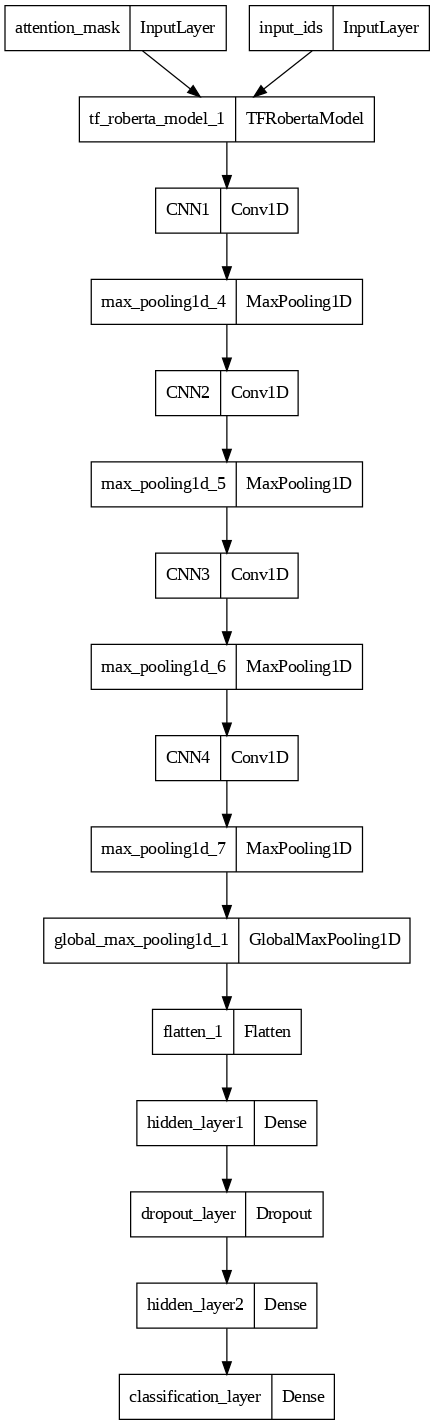

In [25]:
keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [11]:
# Define a callback to save weights after each batch
from tensorflow.keras.callbacks import Callback

class SaveWeightsCallback(Callback):
    def __init__(self, model_name):
        super(SaveWeightsCallback, self).__init__()
        self.model_name = model_name

    #def on_batch_end(self, batch, logs=None):
    #    model_filename = f"/content/drive/My Drive/w266/training/{self.model_name}_weights.h5"
    #    self.model.save_weights(model_filename)

    def on_epoch_end(self, epoch, logs=None):
        model_filename = f"/content/drive/My Drive/w266/training/{self.model_name}_weights_epoch{epoch}.h5"
        self.model.save_weights(model_filename)

# Create a custom callback to stop within a single epoch if accuracy doesn't change much between iterations
class CustomStopCallbackWithinEpoch(Callback):
    def __init__(self, delta=0.01, patience=2, threshold=0.50):
        super(CustomStopCallbackWithinEpoch, self).__init__()
        self.delta = delta
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best_accuracy = -1

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')

        if accuracy is not None and accuracy > self.threshold:
            if np.abs(accuracy - self.best_accuracy) > self.delta:
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    print(f"\nStopping training within epoch {epoch + 1} because accuracy hasn't improved for the last {self.patience} iterations.")
            if accuracy > self.best_accuracy:
              self.best_accuracy = accuracy

In [12]:
save_weights_callback = SaveWeightsCallback(model_name='roberta_multi_bal')
custom_stop_callback = CustomStopCallbackWithinEpoch(delta=0.01, patience=2, threshold=0.7)

In [13]:
# Train the model with the SaveWeightsCallback
#model_history = model.fit(
#    dataset_training,
#    validation_data=dataset_validation,
#    epochs=1,
#    callbacks=[save_weights_callback, custom_stop_callback])

model_history = model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=5,
    callbacks=save_weights_callback)

Epoch 1/5


67/67 [==============================] - 573s 8s/step - loss: 1.5530 - accuracy: 0.3557 - val_loss: 1.7506 - val_accuracy: 0.3056
Epoch 2/5
67/67 [==============================] - 541s 8s/step - loss: 1.1772 - accuracy: 0.5293 - val_loss: 1.7929 - val_accuracy: 0.4252
Epoch 3/5
67/67 [==============================] - 514s 8s/step - loss: 0.8560 - accuracy: 0.6741 - val_loss: 0.7613 - val_accuracy: 0.7143
Epoch 4/5
67/67 [==============================] - 533s 8s/step - loss: 0.5006 - accuracy: 0.8198 - val_loss: 0.6366 - val_accuracy: 0.7907
Epoch 5/5
67/67 [==============================] - 537s 8s/step - loss: 0.3605 - accuracy: 0.8874 - val_loss: 0.6186 - val_accuracy: 0.8173


In [33]:
# AS NEEDED: Reload weights and run for longer
model.load_weights("/content/drive/My Drive/w266/training/roberta_multi_bal_weights_epoch3.h5")

In [34]:
# AS NEEDED: Reload weights and run for longer
model_history = model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=1,
    callbacks=save_weights_callback)

67/67 [==============================] - 550s 8s/step - loss: 0.4466 - accuracy: 0.8392 - val_loss: 0.7865 - val_accuracy: 0.7641


In [14]:
# OPTIONAL: create a smaller Test dataset
test_data_small = []
test_label_small = []
size_factor = 0.2

size = int(size_factor*len(df_test))

for indx, row in df_test.iterrows():
  if indx < size:
    test_data_small.append(row[0])
    test_label_small.append(row[1])
  else:
    break

test_encodings_small, test_enc_label_small = create_encoding(test_data_small, test_label_small)

In [19]:
predictions = model.predict([test_encodings.input_ids, test_encodings.attention_mask])
#predictions = model.predict([test_encodings_small.input_ids, test_encodings_small.attention_mask])

216/216 [==============================] - 500s 2s/step


In [16]:
np.savetxt('/content/drive/My Drive/w266/predictions_roberta_cnn_nn_multi_bal_5epoch_small.csv', predictions)

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

test_type = 'large'

prediction_max = []
for i in range(len(predictions)):
  prediction_max.append(np.argmax(predictions[i]))

# Generate confusion matrix
if test_type == 'small':
  conf_matrix = confusion_matrix(test_label_small, prediction_max)
else:
  conf_matrix = confusion_matrix(test_label, prediction_max)


# Calculate accuracy using TensorFlow
accuracy = tf.keras.metrics.Accuracy()
if test_type == 'small':
  accuracy.update_state(test_label_small, prediction_max)
else:
  accuracy.update_state(test_label, prediction_max)
accuracy_result = accuracy.result().numpy()

# Calculate precision, recall, and F1 score using TensorFlow
precision = tf.keras.metrics.Precision()
if test_type == 'small':
  precision.update_state(test_label_small, prediction_max)
else:
  precision.update_state(test_label, prediction_max)
precision_result = precision.result().numpy()

recall = tf.keras.metrics.Recall()
if test_type == 'small':
  recall.update_state(test_label_small, prediction_max)
else:
  recall.update_state(test_label, prediction_max)
recall_result = recall.result().numpy()

f1 = 2 * (precision_result * recall_result) / (precision_result + recall_result)

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy_result)
print("\nPrecision:", precision_result)
print("Recall:", recall_result)
print("F1 Score:", f1)

# Classification report using scikit-learn
if test_type == 'small':
  class_report = classification_report(test_label_small, prediction_max)
else:
  class_report = classification_report(test_label, prediction_max)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[ 848   26   37   40    9  100    9]
 [   7  528   37   12    1   27    4]
 [   7    6 1505   63  126  152   29]
 [   4    6  304  801   68   41    2]
 [   1    0   52   15  901    5    5]
 [  17    2   57    7    7  578    9]
 [   0    0    1    1    5    4  422]]

Accuracy: 0.8105401

Precision: 0.9631912
Recall: 0.9938134
F1 Score: 0.9782627817401762

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1069
           1       0.93      0.86      0.89       616
           2       0.76      0.80      0.78      1888
           3       0.85      0.65      0.74      1226
           4       0.81      0.92      0.86       979
           5       0.64      0.85      0.73       677
           6       0.88      0.97      0.92       433

    accuracy                           0.81      6888
   macro avg       0.83      0.84      0.83      6888
weighted avg       0.82      0.81      0.81      6888



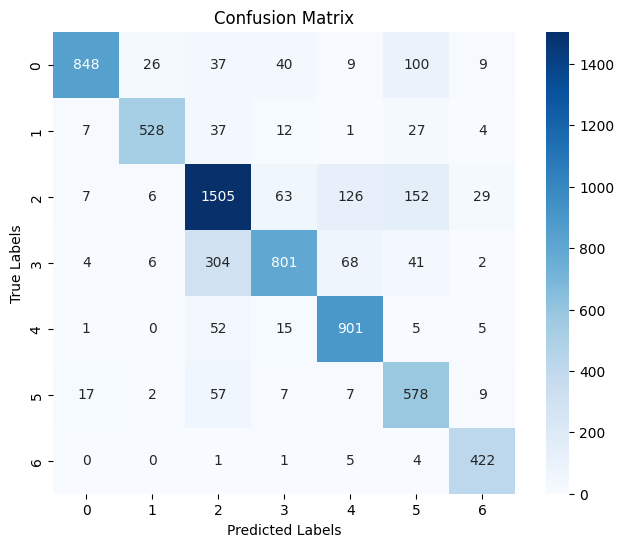

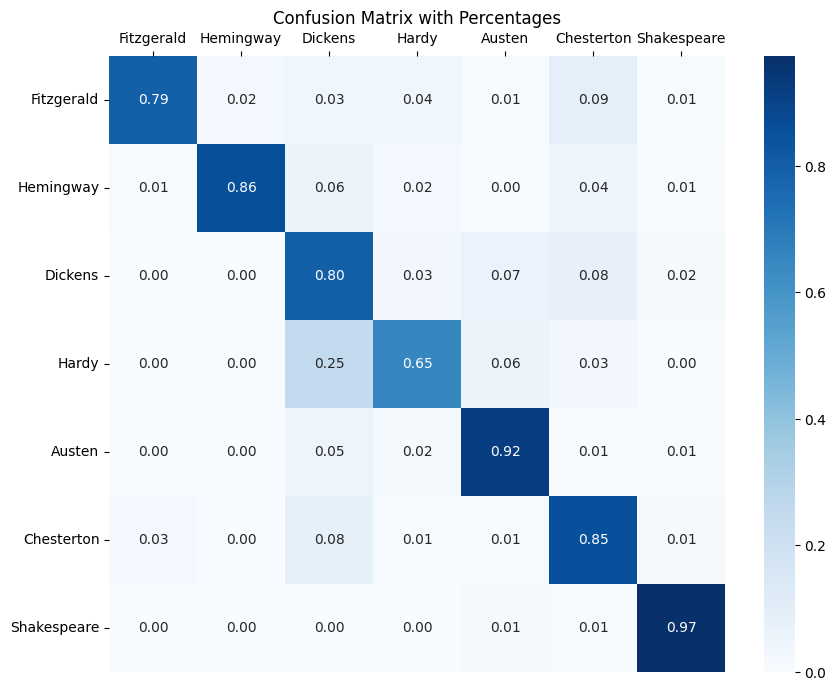

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", square=True, xticklabels=True, yticklabels=True)
# Set row labels
class_labels = ["Fitzgerald", "Hemingway", "Dickens", "Hardy", "Austen", "Chesterton", "Shakespeare"]
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
ax = plt.gca()
ax.xaxis.set_ticks_position("top")

# Add a title
plt.title("Confusion Matrix with Percentages")
plt.show()

In [ ]:
test_label[0:20]

[1, 4, 4, 0, 1, 5, 3, 3, 6, 5, 5, 0, 2, 2, 0, 2, 2, 2, 3, 2]